# CLIP encoder


In [1]:
import recipe_parser as rp
import search 
import index 
import torch
from PIL import Image
import requests 
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM, CLIPTokenizerFast, CLIPTextConfig, CLIPVisionConfig, CLIPConfig
import matplotlib.pyplot as plt
import pickle
import os
import random


In [2]:
device =  "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device}. If not using mps, remember to change the .to('mps') to .to(device) in the code")

Using mps. If not using mps, remember to change the .to('mps') to .to(device) in the code


In [3]:

# Initializing a CLIPConfig with openai/clip-vit-base-patch32 style configuration
configuration = CLIPConfig()

# Initializing a CLIPModel (with random weights) from the openai/clip-vit-base-patch32 style configuration
model = CLIPModel(configuration).to('mps')

# Accessing the model configuration
configuration = model.config

# We can also initialize a CLIPConfig from a CLIPTextConfig and a CLIPVisionConfig


# Initializing a CLIPText and CLIPVision configuration
config_text = CLIPTextConfig(max_position_embeddings=512)
config_vision = CLIPVisionConfig()

config = CLIPConfig.from_text_vision_configs(config_text, config_vision)

### Data processing


In [4]:

recipes_images =[]

if os.path.exists("pickle_files/recipes_images.pkl"):
    recipes_images = pickle.load(open("pickle_files/recipes_images.pkl", "rb"))
else:
    for key in rp.get_recipes():
        if (rp.get_recipes()[key]['images'] != []):
            recipes_images.append(rp.get_recipes()[key]['images'][0]['url'])
    pickle.dump(recipes_images, open("pickle_files/recipes_images.pkl", "wb"))



In [5]:
if os.path.exists("pickle_files/recipes_images.pkl"):
    recipes_images = pickle.load(open("pickle_files/recipes_images.pkl", "rb"))
else:
    pickle.dump(recipes_images, open("pickle_files/recipes_images.pkl", "wb"))

In [6]:
if os.path.exists('pickle_files/recipe_titles.pkl'):
    titles = pickle.load(open('pickle_files/recipe_titles.pkl', 'rb'))
else:
    titles = rp.get_recipe_titles()

### Recipe image selection

https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/foodnetwork/b9de468dc371a93bd3a9d9bdb0acec13bba229d215488711d1510199b237ff04.jpg


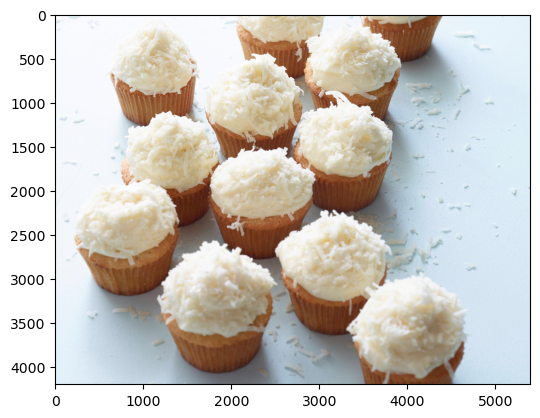

In [7]:
url = random.choice(recipes_images)
url = recipes_images[444]
print(url)
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()

### CLIP execution

In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")


image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=titles, images=image, return_tensors="pt", padding=True).to('mps')
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)

### Top 5 most probable recipes

In [9]:
len(probs)


1

In [10]:
top_k = 5
values, indices = torch.topk(probs, top_k)
values, indices

(tensor([[0.0024, 0.0021, 0.0021, 0.0021, 0.0021]], device='mps:0',
        grad_fn=<TopkBackward0>),
 tensor([[166, 319, 161, 178, 617]], device='mps:0'))

In [11]:
#return first value of values
index = indices[0][0].item()
print(f"The most probable recipe is: {titles[index]}")

The most probable recipe is: Chocolate Strawberry Trees


### Trying to guess in which step Im in

In [12]:
index
if os.path.exists('pickle_files/recipe_steps.pkl'):
    steps = pickle.load(open('pickle_files/recipe_steps.pkl', 'rb'))
else:
    steps = rp.get_recipe_steps()


In [13]:
steps[index]

['In a double boiler, melt the chocolate bars. Take 3 quarts of the strawberries and dip individual strawberries half-way into the chocolate and set on waxed paper to dry in the refrigerator.',
 'To assemble trees: Starting at the bottom, toothpick 1 plain strawberry (stem side in) into styrofoam, then toothpick a chocolate strawberry (stem side in) into Styrofoam. Alternate plain and chocolate moving around the tree until it is covered with strawberries. Top the tree with 1 strawberry facing up vertically.']

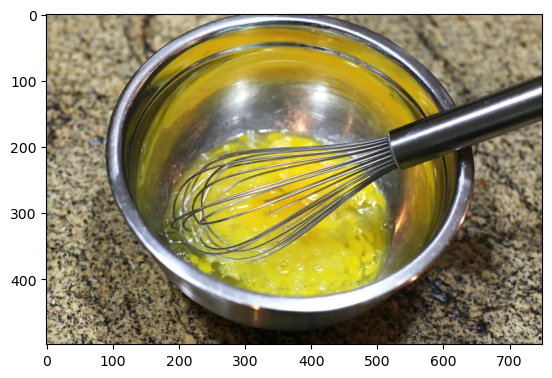

In [14]:
step_image_url = 'https://www.thespruceeats.com/thmb/okcG3hrlQnpE1BOCRV7GS6_MmM8=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/beat-whisk-eggs-18-56a8c1ca3df78cf772a059eb.jpg'
step_image = Image.open(requests.get(step_image_url, stream=True).raw)
plt.imshow(step_image)
plt.show()

In [15]:
steps[index]

['In a double boiler, melt the chocolate bars. Take 3 quarts of the strawberries and dip individual strawberries half-way into the chocolate and set on waxed paper to dry in the refrigerator.',
 'To assemble trees: Starting at the bottom, toothpick 1 plain strawberry (stem side in) into styrofoam, then toothpick a chocolate strawberry (stem side in) into Styrofoam. Alternate plain and chocolate moving around the tree until it is covered with strawberries. Top the tree with 1 strawberry facing up vertically.']

In [16]:
# Load the image
image = Image.open(requests.get(step_image_url, stream=True).raw)

# Process the text and image
inputs = processor(text=steps[index], images=[image], return_tensors="pt", padding=True)



# Get model outputs
outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)



RuntimeError: slow_conv2d_forward_mps: input(device='cpu') and weight(device=mps:0')  must be on the same device

In [ ]:
len

1